In [2]:
%matplotlib inline
from pylab import *

In [3]:
from sklearn import datasets
olivetti = datasets.fetch_olivetti_faces(data_home="D:\Users\S36733\scikit_learn_data")
X, y = olivetti.data, olivetti.target

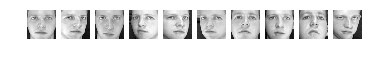

In [3]:
for i in range(10):
    face = olivetti.images[i]
    subplot(1, 10, i + 1)
    imshow(face.reshape((64, 64)), cmap='gray')
    axis('off')

In [4]:
smiling_indices = [20,21,26,27,29, 40,41,42,43,44,45,46,\
                   47,48,49,50, 51, 52,61,69,70,72,75, 86,90,91,92, 93, 95,111,\
                   114,116,119,123,129,141,153,160,161,\
                   162,163,164,167,174,186,190,191,197,\
                   200,201,202,213,214,216,217, 219, 234,240,242,246,\
                   255,260,261,268,276,300,303, 305,310, 311,312, 313, 314, 315, 316,\
                   324,325, 326, 327, 328, 340,341,342, 343,\
                   348,349, 367,380,381,382,383,384,385,386,387,\
                   388,390, 391,393,396,397,399]

not_smiling_indices = list(set(range(400)) - set(smiling_indices))

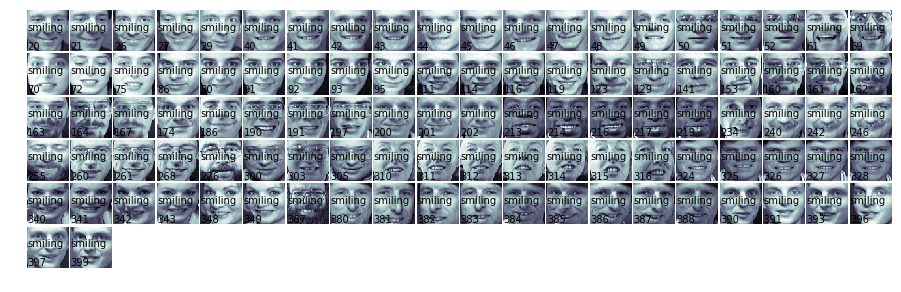

In [14]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(olivetti.images[smiling_indices[i]], cmap=plt.cm.bone)
    
    # label the image with the target value
    p.text(0, 30, "smiling")
    p.text(0, 60, str(smiling_indices[i]))
    p.axis('off')


In [ ]:

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(not_smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(olivetti.images[not_smiling_indices[i]], cmap=plt.cm.bone)

    # label the image with the target value
    p.text(0, 30, "not smiling")
    p.text(0, 60, str(not_smiling_indices[i]))
    p.axis('off')

In [81]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
#svc_1 = SVC(kernel='linear', class_weight={1:3}, C=100, probability=True)
svc_1 = SVC(kernel='linear', probability=True)

# svc_1 = MLPClassifier(hidden_layer_sizes=2, shuffle=True, activation='logistic')

data = olivetti.data

target = []
for i in range(400):
    if(i in smiling_indices):
        target.append(1)
    else:
        target.append(0)
        

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.3, random_state=0)

In [83]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(n_splits=K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

In [84]:
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[ 0.82142857  0.82142857  0.85714286  0.78571429  0.83928571]
Mean score: 0.825 (+/-0.012)


In [85]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [86]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.841666666667
Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.90      0.89        88
          1       0.71      0.69      0.70        32

avg / total       0.84      0.84      0.84       120

Confusion Matrix:
[[79  9]
 [10 22]]


In [87]:
import cv2
from scipy.ndimage import zoom

def detect_face(frame):
    cascPath = "D:\\Users\\S36733\\AppData\\Local\\Continuum\\anaconda2\\Library\\etc\\haarcascades\\haarcascade_frontalface_default.xml"

    faceCascade = cv2.CascadeClassifier(cascPath)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=6,
            minSize=(100, 100)
        )
    return gray, detected_faces

def extract_face_features(gray, detected_face, offset_coefficients):
    x, y, w, h = detected_face
    horizontal_offset = int(offset_coefficients[0] * w)
    vertical_offset = int(offset_coefficients[1] * h)
    extracted_face = gray[y+vertical_offset:y+h, 
                      x+horizontal_offset:x-horizontal_offset+w]
    new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))
    new_extracted_face = new_extracted_face.astype(float32)
    new_extracted_face /= float(new_extracted_face.max())
    return new_extracted_face

def predict_face_is_smiling(extracted_face):
    return svc_1.predict(extracted_face.ravel().reshape(1,-1))

def predict_face_is_smiling_proba(extracted_face):
    return round(svc_1.predict_proba(extracted_face.ravel().reshape(1,-1))[0,1], 2)

In [89]:
video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    # detect faces
    gray, detected_faces = detect_face(frame)
    
    face_index = 0
    
    # predict output
    for face in detected_faces:
        (x, y, w, h) = face
        if w > 100:
            # draw rectangle around face 
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # extract features
            extracted_face = extract_face_features(gray, face, (0.1, 0.06)) #(0.075, 0.05)

            # predict smile
            # prediction_result = predict_face_is_smiling(extracted_face)
            prediction_proba = predict_face_is_smiling_proba(extracted_face)

            # draw extracted face in the top right corner
            frame[face_index * 64: (face_index + 1) * 64, -65:-1, :] = cv2.cvtColor(extracted_face * 255, cv2.COLOR_GRAY2RGB)

            cv2.putText(frame, "Proba de sourire:" + str(prediction_proba), (5,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (155,255,255), 2, cv2.LINE_AA)
            # annotate main image with a label
            #if prediction_result == 1:
            if prediction_proba >= 0.4:
                cv2.putText(frame, "Sourire",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, cv2.LINE_4)
            else:
                cv2.putText(frame, "Pas de sourire",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, cv2.LINE_4)

            # increment counter
            face_index += 1
                

    # Display the resulting frame
    cv2.namedWindow('Video', cv2.WND_PROP_ASPECT_RATIO)
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()